<h1>Setup</h1>

In [55]:
# Importing the necessary libraries I will use for this project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

In [4]:
# Loading data from a CSV file
df = pd.read_csv(r'/Users/alina/Documents/Analytics Portfoilio/Game Funnel Analysis/plr_smpl_attempts.csv', sep=';')

In [5]:
# Looking at the data
df.head()

uid  action  level     event_time
0  elljQ2EySG03MDU0MTE3MTAyMTE3MA  failed    113  1512086924640
1  elljQ2EySG03MDU0MTE3MTAyMTE3MA  failed    113  1512086924640
2  elljQ2EySG03MDU0MTE3MTAyMTE3MA  failed    113  1512086924640
3  elljQ2EySG03MDU0MTE3MTAyMTE3MA  failed    113  1512086924640
4  elljQ2EySG03MDU0MTE3MTAyMTE3MA  failed    113  1512086924640

<h1>Data Cleaning</h1>

In [6]:
# Let's look through the data and see if there is anything missing
for col in df.columns:
    percent_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, round(percent_missing*100)))

uid - 0%
action - 0%
level - 0%
event_time - 0%


In [7]:
# Dropping duplicates
df.drop_duplicates(inplace=True)
# Dropping indexes
df.reset_index(drop=True, inplace=True)

In [8]:
# Checking the data type of the columns
print(df.dtypes)

uid           object
action        object
level          int64
event_time     int64
dtype: object


<h1>Preparing Data For Analysis</h1>
In my analysis, I examined the level progression funnel only for new users

In [9]:
# Counting unique users
df['uid'].nunique()

196088

In [10]:
# Filtering Data for new users only (users whos data is availeble from the 1st level in this dataset)
new_users = df[df['level'] == 1]

In [11]:
# Counting unique new users
new_users['uid'].nunique()

24162

In [12]:
# Creating list of ids for new unique users
unique_new_users = new_users['uid'].unique().tolist()

In [13]:
# Creating new DataFrame which consist ids of unique new users only
dh = df[df['uid'].isin(unique_new_users)]

In [14]:
# Dropping indexes
dh.reset_index(drop=True, inplace=True)

In [34]:
# Creating a copy of the DataFrame for ease of manipulation
filtered_dh = dh.copy()

# Converting the 'level' column to a string type
filtered_dh['level'] = filtered_dh['level'].astype(str)

# List for storing funnel data
funnel_data = []  

# We go through each level
for level in range(1, 301):
    level_data = filtered_dh[filtered_dh['level'] == str(level)]

    # Calculating metrics for a specific level
    count_of_attempts = level_data['action'].count()
    passed_users = len(level_data[(level_data['action'] == 'completed')]['uid'].unique())
    failed_users = len(level_data[(level_data['action'] == 'failed')]['uid'].unique())
    count_of_wins = len(level_data[level_data['action'] == 'completed'])
    count_of_failes = len(level_data[level_data['action'] == 'failed'])
    total_users = level_data['uid'].nunique()
    conversion_rate = round((total_users / dh['uid'].nunique())*100, 2) if total_users != 0 else 0
    AVG_count_of_fails_per_user = round(count_of_failes / failed_users, 1)

    # Finding the next level's data
    next_level_data = filtered_dh[filtered_dh['level'] == str(level + 1)]
    next_total_users = next_level_data['uid'].nunique() if not next_level_data.empty else 0
    next_conversion_rate = next_total_users / dh['uid'].nunique() if next_total_users != 0 else 0

    # Calculating the difference in conversion rates
    conversion_rate_difference = round((((total_users / dh['uid'].nunique()) / next_conversion_rate) - 1)*100, 2)
    
    # Finding the previous level's data
    prev_level_data = filtered_dh[filtered_dh['level'] == str(level - 1)]
    prev_total_users = prev_level_data['uid'].nunique() if not prev_level_data.empty else 0
    
    # Calculating sequential conversion rate
    sequential_conversion_rate = round((total_users / prev_total_users)*100, 2) if prev_total_users != 0 else 0
    
    # Calcultaing level difficulty
    p_win = count_of_wins / count_of_attempts

    # Calcultaing the standard error of p_win
    std_error = (p_win*(1-p_win) / count_of_attempts) ** 0.5
    
    # Adding funnel data to a list
    funnel_data.append([level, count_of_attempts, passed_users, failed_users, count_of_wins, count_of_failes, AVG_count_of_fails_per_user, total_users, conversion_rate, conversion_rate_difference, sequential_conversion_rate, p_win])
    
# Creating a DataFrame for a Funnel
funnel_dh = pd.DataFrame(funnel_data, columns=['Level', 'Total attempts', 'Users completed the level', 'Users failed the level', 'Count of wins', 'Count of failes', 'AVG count of fails per user', 'Total users', 'Conversion rate', 'Conversion rate difference','Sequential conversion rate', 'P_win'])

funnel_dh

Level  Total attempts  Users completed the level  Users failed the level  \
0        1           25113                      24157                      11   
1        2           22547                      21515                     509   
2        3           22313                      20347                    1410   
3        4           20382                      19762                     157   
4        5           23887                      18984                    4021   
..     ...             ...                        ...                     ...   
295    296              62                         25                      19   
296    297              54                         27                      18   
297    298              58                         27                      22   
298    299              88                         28                      26   
299    300             115                         27                      25   

     Count of wins  Count of failes  AVG count of fails per user  Total users  \
0            25096               17                          1.5        24162   
1            21960              587                          1.2        21625   
2            20792             1521                          1.1        20472   
3            20206              176                          1.1        19780   
4            19435             4452                          1.1        19247   
..             ...              ...                          ...          ...   
295             25               37                          1.9           25   
296             28               26                          1.4           28   
297             28               30                          1.4           27   
298             28               60                          2.3           28   
299             27               88                          3.5           29   

     Conversion rate  Conversion rate difference  Sequential conversion rate  \
0             100.00                       11.73                        0.00   
1              89.50                        5.63                       89.50   
2              84.73                        3.50                       94.67   
3              81.86                        2.77                       96.62   
4              79.66                        5.60                       97.31   
..               ...                         ...                         ...   
295             0.10                      -10.71                       96.15   
296             0.12                        3.70                      112.00   
297             0.11                       -3.57                       96.43   
298             0.12                       -3.45                      103.70   
299             0.12                        3.57                      103.57   

        P_win  
0    0.999323  
1    0.973965  
2    0.931833  
3    0.991365  
4    0.813622  
..        ...  
295  0.403226  
296  0.518519  
297  0.482759  
298  0.318182  
299  0.234783  

[300 rows x 12 columns]

<h1>Analysing Data</h1>

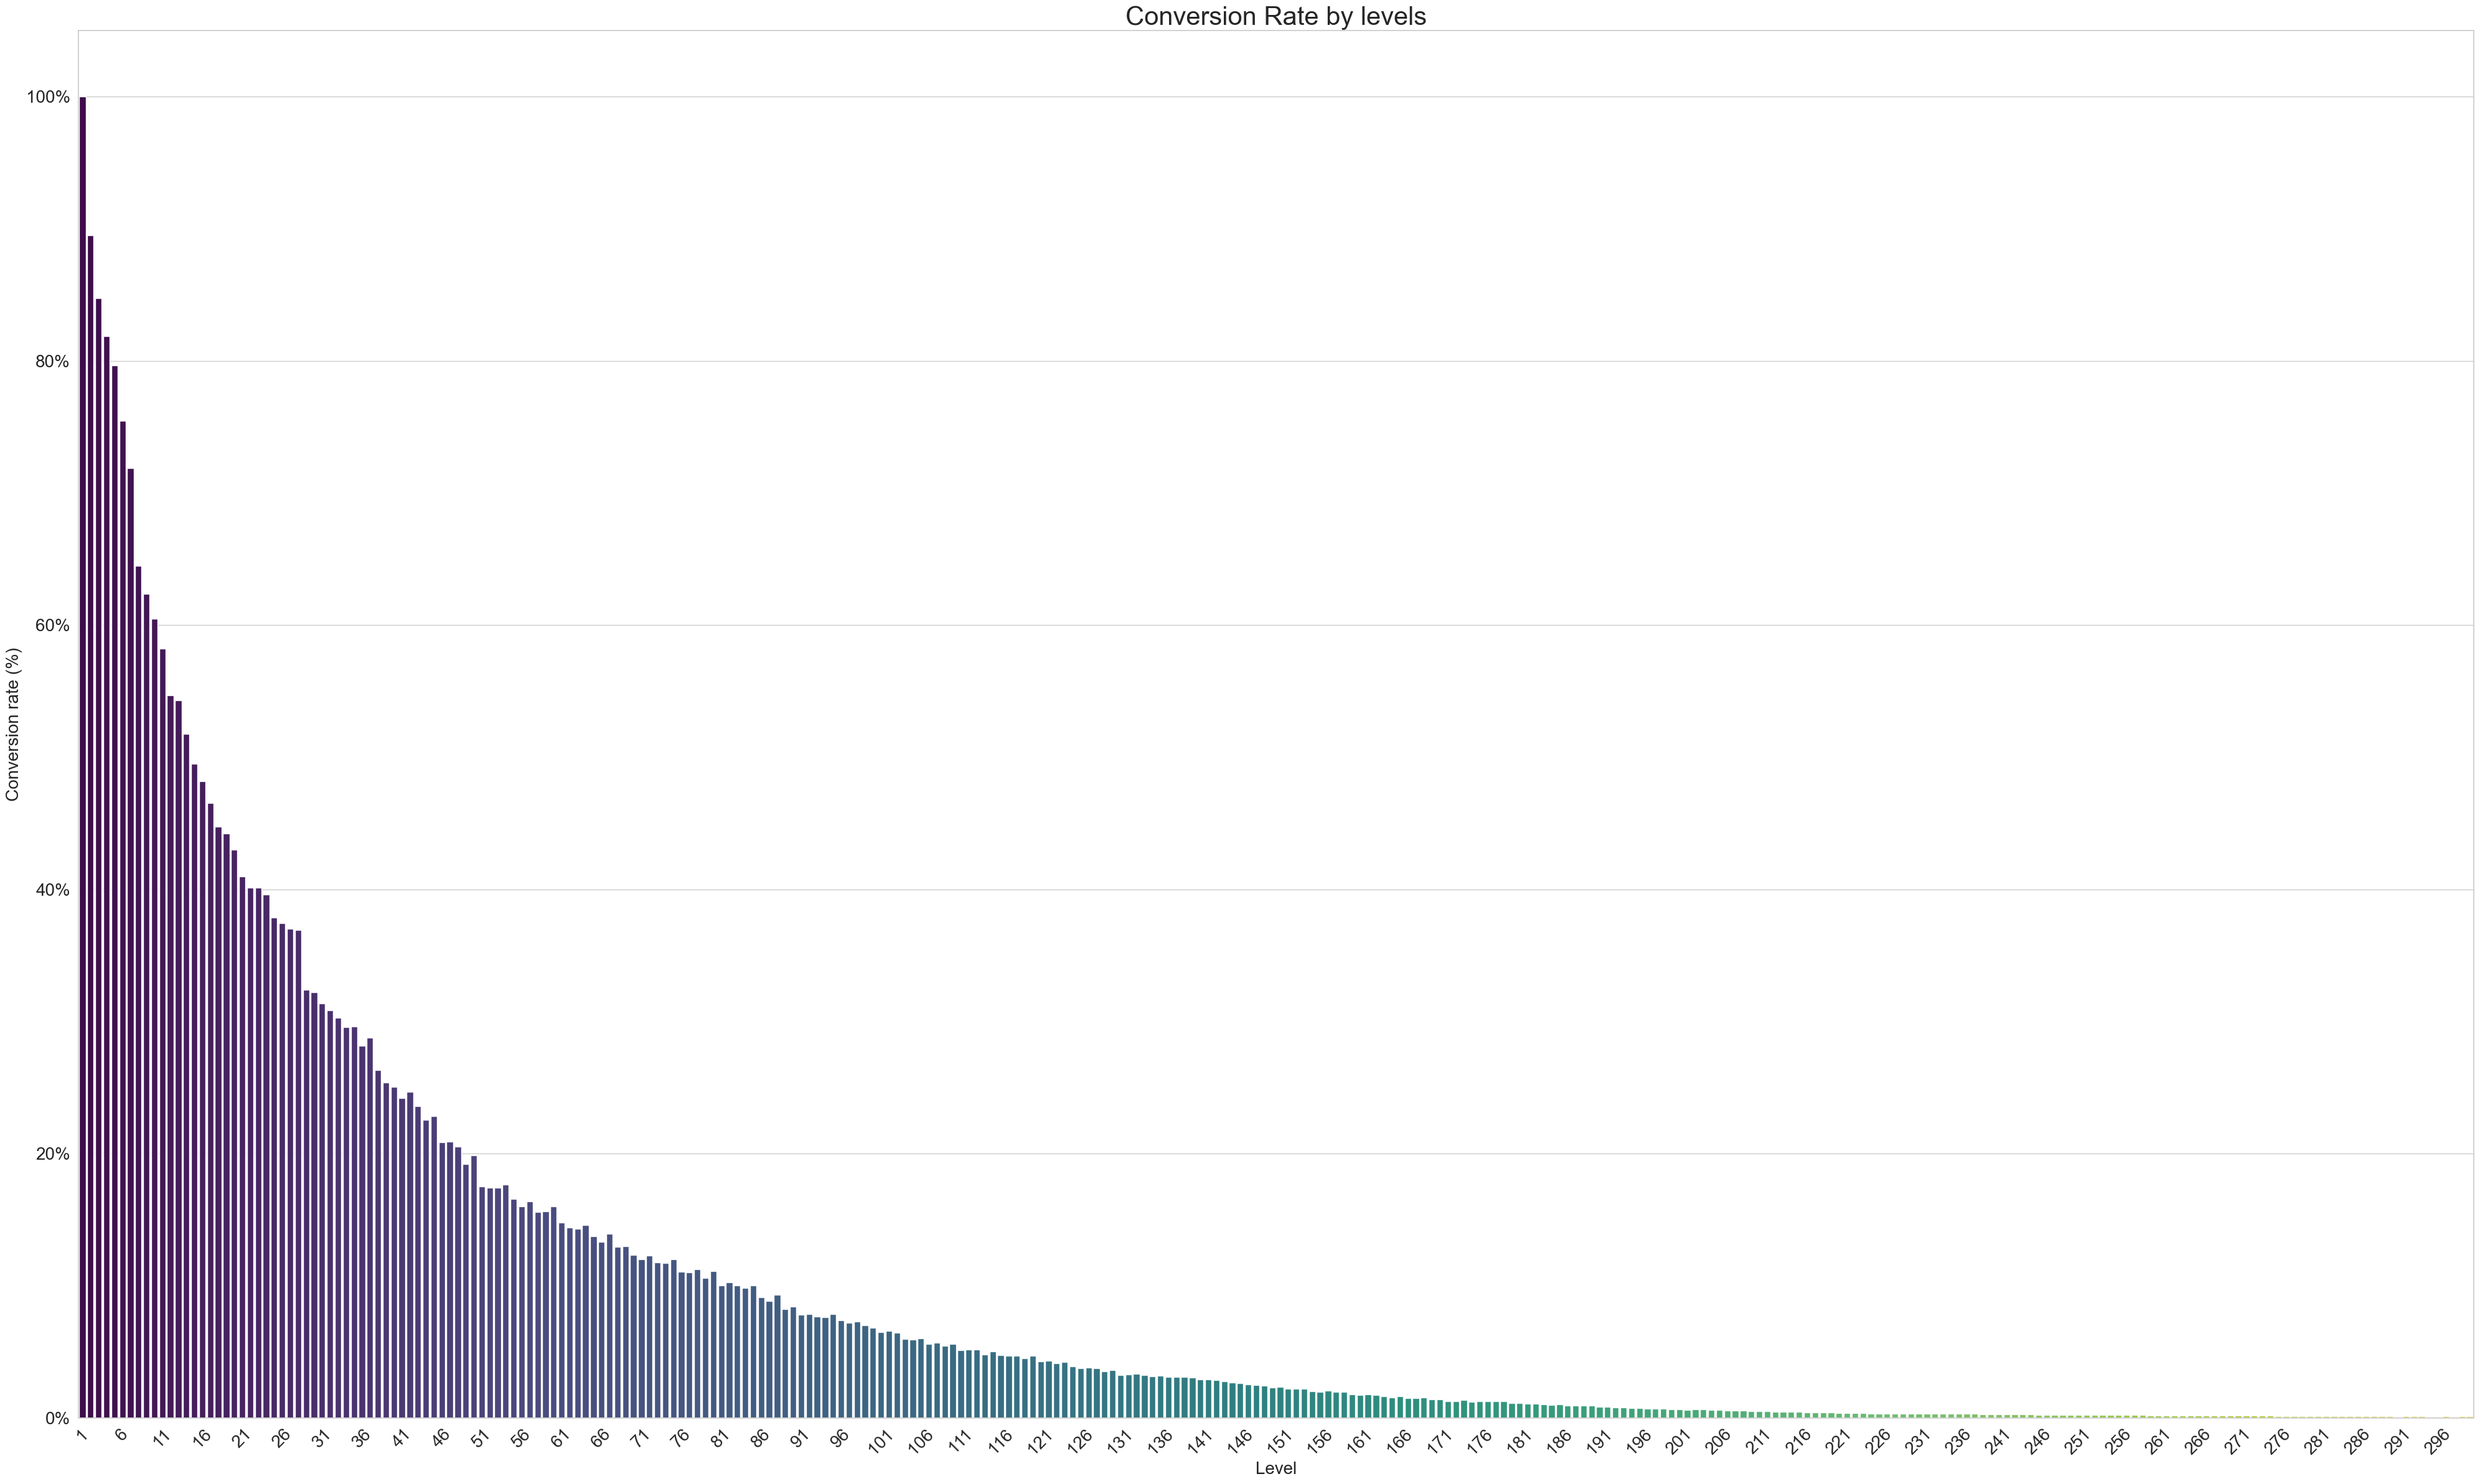

In [16]:
# Creating the chart with the Conversion Rate

# Setting the chart style
sns.set(style="whitegrid")

# Creating a Column Chart Using Seaborn
plt.figure(figsize=(40, 24))
plot = sns.barplot(x='Level', y='Conversion rate', data=funnel_dh, palette='viridis')
plt.xlabel('Level', size=20)
plt.ylabel('Conversion rate (%)', size=20)
plt.title('Conversion Rate by levels', size=30)

# Setting Y-Axis Percentage Labels
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda value, _: f'{value:.0f}%'))
plt.yticks(fontsize=20)

# Display every 10th tick mark on x-axis
plot.set_xticks(range(0, len(funnel_dh['Level']), 5))
plot.set_xticklabels(funnel_dh['Level'][::5], fontsize=20)

plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

Here is a conversion rate funnel that shows the percentage of users who played at a certain level, relative to the number of all new users available in the dataset. We can observe that there are no serious spikes in the conversion funnel and the graph shows a classic smooth decrease in conversion, however, further we will look at the areas with the largest drop, which can be studied in more detail and based on this the product team can develop strategies to improve product performance metrics. The development team can use this funnel to analyze if game balance is working correctly and if there are areas for improvement in the difficulty curve to reduce user churn (but futher we will take a look at difficulty using Bernoulli process), or looking for areas where the monetization strategy can be improved (add offers for in-app purchases with boosters, and other, or offers to “watch ads to earn rewards”).

In [17]:
# Creating the funnel for Conversion Rate
fig = go.Figure()

fig.add_trace(go.Funnel(
    x=funnel_dh['Conversion rate'],
    y=funnel_dh['Level'],
    textinfo="value+percent previous",
    name='Conversion Rate Funnel'
))

fig.update_layout(
    title='Conversion Rate Funnel',
    xaxis_title='Conversion Rate (%)',
    yaxis_title='Level',
    width=800,
    height=500
)

fig.show()

In [18]:
# Sorting data by Conversion rate difference to see top10 levels with the highest drop in conversion (difference between the current level and the next one)
funnel_dh_sorted_conv = funnel_dh.sort_values(by=['Conversion rate difference'], ascending = False)
funnel_dh_sorted_conv.set_index('Level', inplace=True)
selected_columns = ['Conversion rate difference']
funnel_dh_sorted_conv[selected_columns].head(20)

Conversion rate difference
Level                            
179                         14.55
28                          14.03
50                          13.56
88                          13.42
130                         11.82
1                           11.73
7                           11.43
80                          11.07
289                         10.71
159                         10.70
259                         10.42
190                         10.40
169                         10.03
285                         10.00
166                          9.89
174                          9.67
120                          9.48
45                           9.45
85                           9.36
37                           9.34

Here we can see a list of the Top levels with the largest drop in conversion rate.

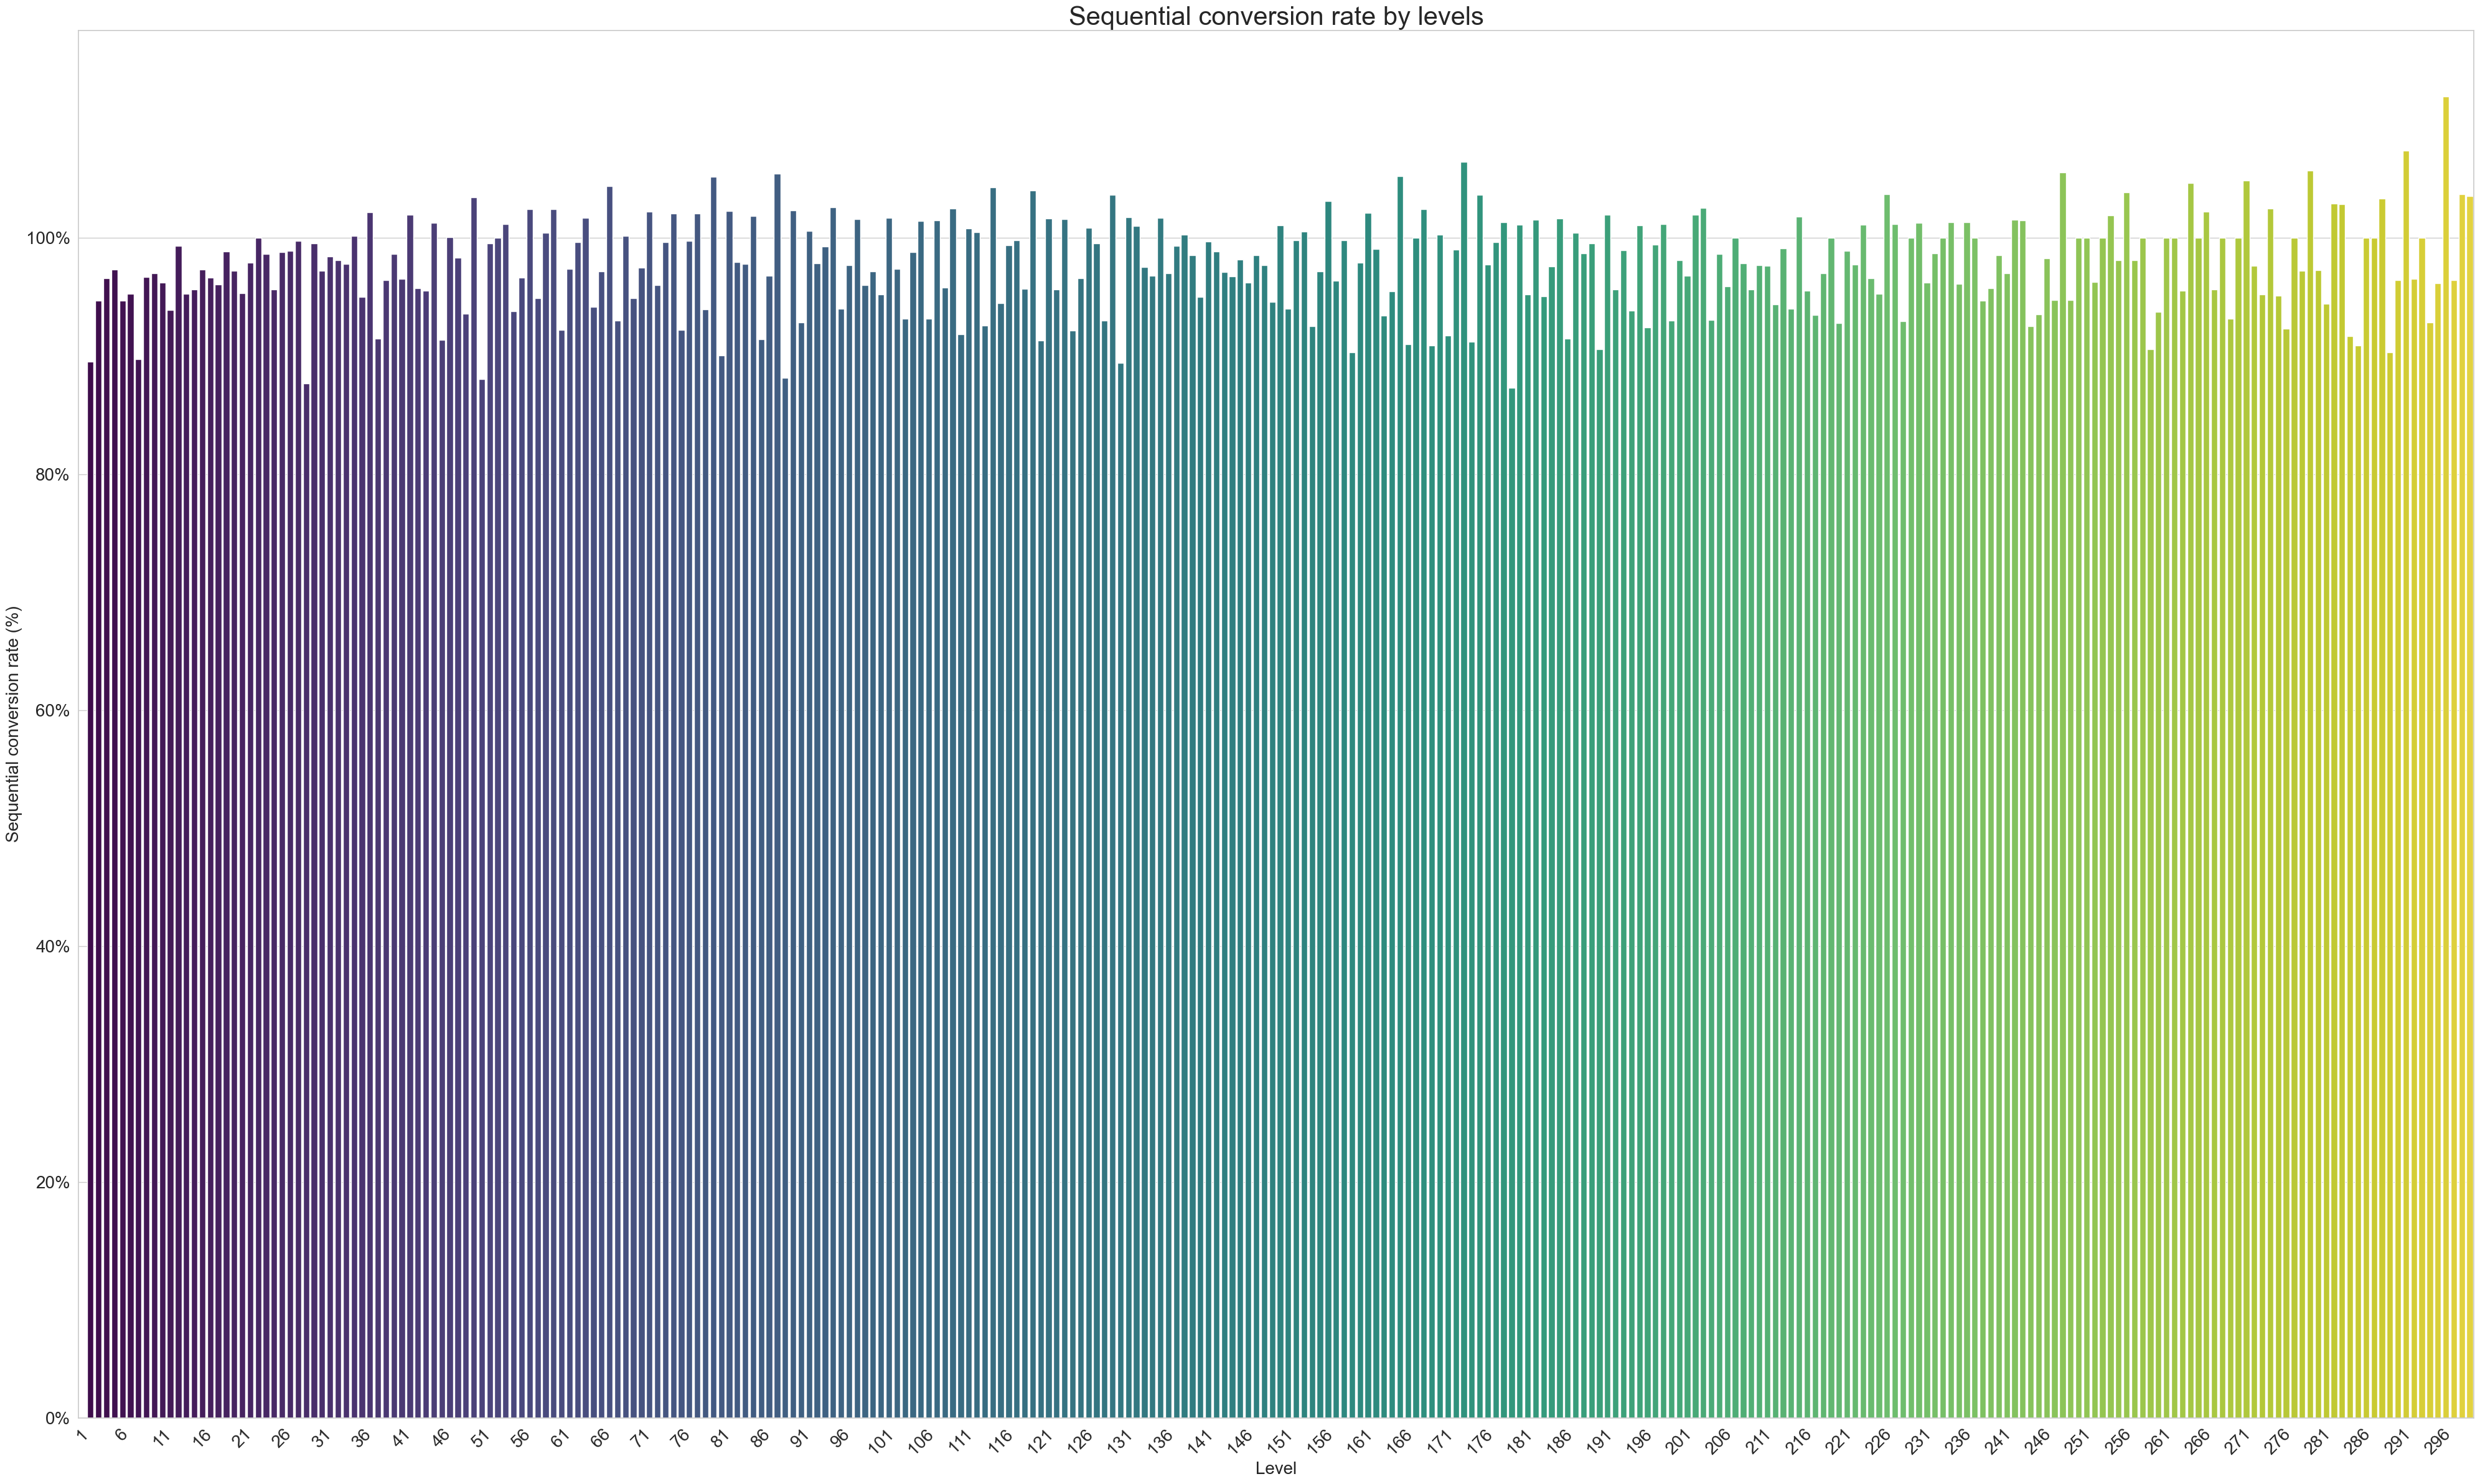

In [19]:
# Creating the chart with the Sequential Conversion Rate

# Setting the chart style
sns.set(style="whitegrid")

# Creating a Column Chart Using Seaborn
plt.figure(figsize=(40, 24))
plot = sns.barplot(x='Level', y='Sequential conversion rate', data=funnel_dh, palette='viridis')
plt.xlabel('Level', size=20)
plt.ylabel('Sequential conversion rate (%)', size=20)
plt.title('Sequential conversion rate by levels', size=30)

# Setting Y-Axis Percentage Labels
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda value, _: f'{value:.0f}%'))
plt.yticks(fontsize=20)

# Display every 10th tick mark on x-axis
plot.set_xticks(range(0, len(funnel_dh['Level']), 5))
plot.set_xticklabels(funnel_dh['Level'][::5], fontsize=20)

plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

Here we can see the chart of Sequential conversion rate which illustrates the distribution of conversions across all levels.

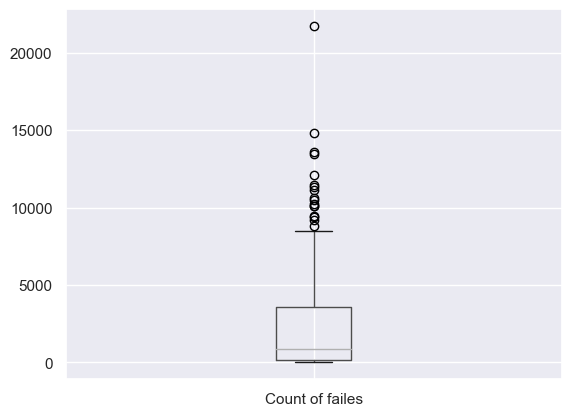

In [20]:
sns.set_theme(style = 'darkgrid')
funnel_dh.boxplot(column=['Count of failes'])
plt.show()

Here we can observe the spread in the number of unsuccessful attempts to complete the level by levels. And, as we see, there are some values in the dataset with very high values, let's look in more detail at what levels these values occur.

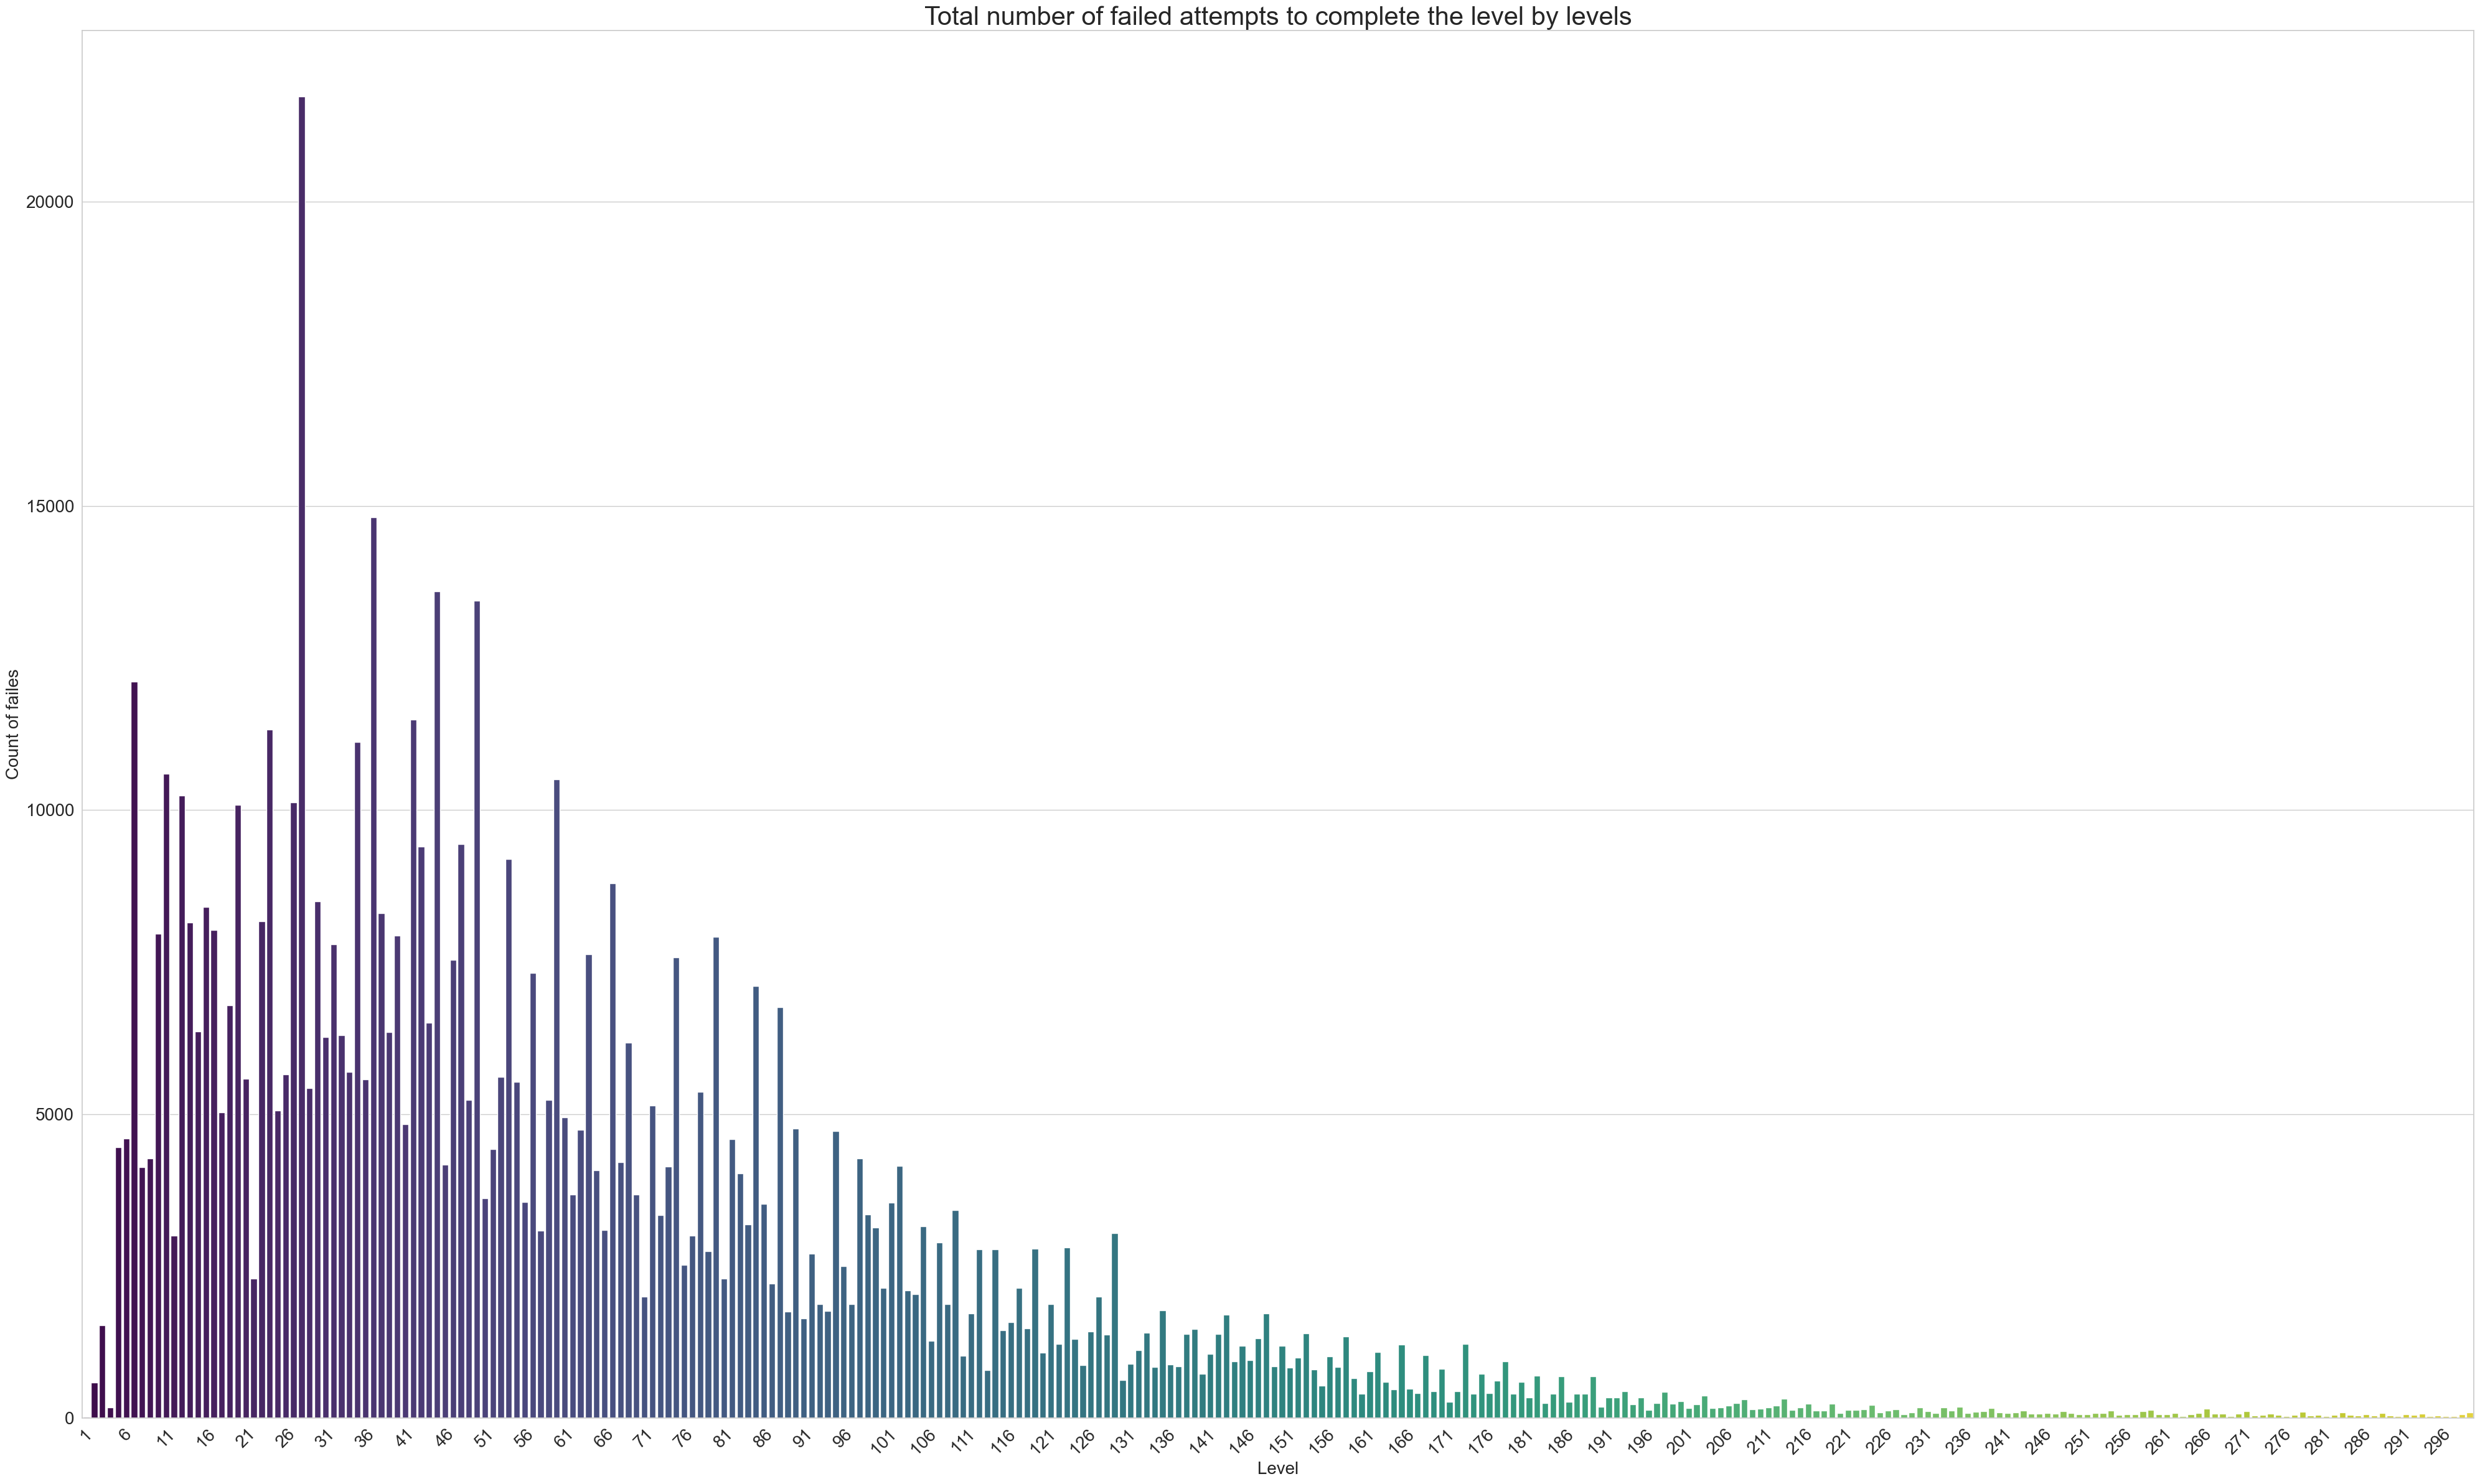

In [21]:
# Building a Chart with the total number of failed attempts to complere the level by levels

# Setting the chart style
sns.set(style="whitegrid")

# Creating a Column Chart Using Seaborn
plt.figure(figsize=(40, 24))
plot = sns.barplot(x='Level', y='Count of failes', data=funnel_dh, palette='viridis')
plt.xlabel('Level', size=20)
plt.ylabel('Count of failes', size=20)
plt.title('Total number of failed attempts to complete the level by levels', size=30)

# Setting Y-Axis Percentage Labels
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda value, _: f'{value:.0f}'))
plt.yticks(fontsize=20)

# Display every 10th tick mark on x-axis
plot.set_xticks(range(0, len(funnel_dh['Level']), 5))
plot.set_xticklabels(funnel_dh['Level'][::5], fontsize=20)

plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

So, as we see on the chart, the highest numbers are found at the first ~60 levels. Let's check what levels these are.

In [22]:
# Sorting data by count of fails
funnel_dh_sorted_fails = funnel_dh.sort_values(by=['Count of failes'], ascending = False)
funnel_dh_sorted_fails.set_index('Level', inplace=True)
selected_columns = ['Count of failes','AVG count of fails per user','Users failed the level','Total users','Conversion rate difference']
funnel_dh_sorted_fails[selected_columns].head(15)

Count of failes  AVG count of fails per user  Users failed the level  \
Level                                                                         
28               21735                          2.8                    7661   
37               14819                          2.5                    5893   
45               13597                          2.8                    4865   
50               13439                          3.1                    4307   
7                12115                          1.4                    8890   
42               11486                          2.3                    4960   
24               11322                          1.6                    6956   
35               11114                          2.0                    5438   
11               10600                          1.5                    7294   
60               10508                          3.0                    3488   
13               10237                          1.4                    7079   
27               10129                          1.7                    5986   
20               10085                          1.6                    6496   
48                9436                          2.3                    4185   
43                9401                          2.1                    4402   

       Total users  Conversion rate difference  
Level                                           
28            8926                       14.03  
37            6955                        9.34  
45            5522                        9.45  
50            4808                       13.56  
7            17362                       11.43  
42            5960                        4.45  
24            9570                        4.53  
35            7164                        5.28  
11           14071                        6.49  
60            3870                        8.43  
13           13125                        4.95  
27            8948                        0.25  
20           10390                        4.90  
48            4965                        6.84  
43            5706                        4.68

Btw, let's check now the average number of fails per user by levels.

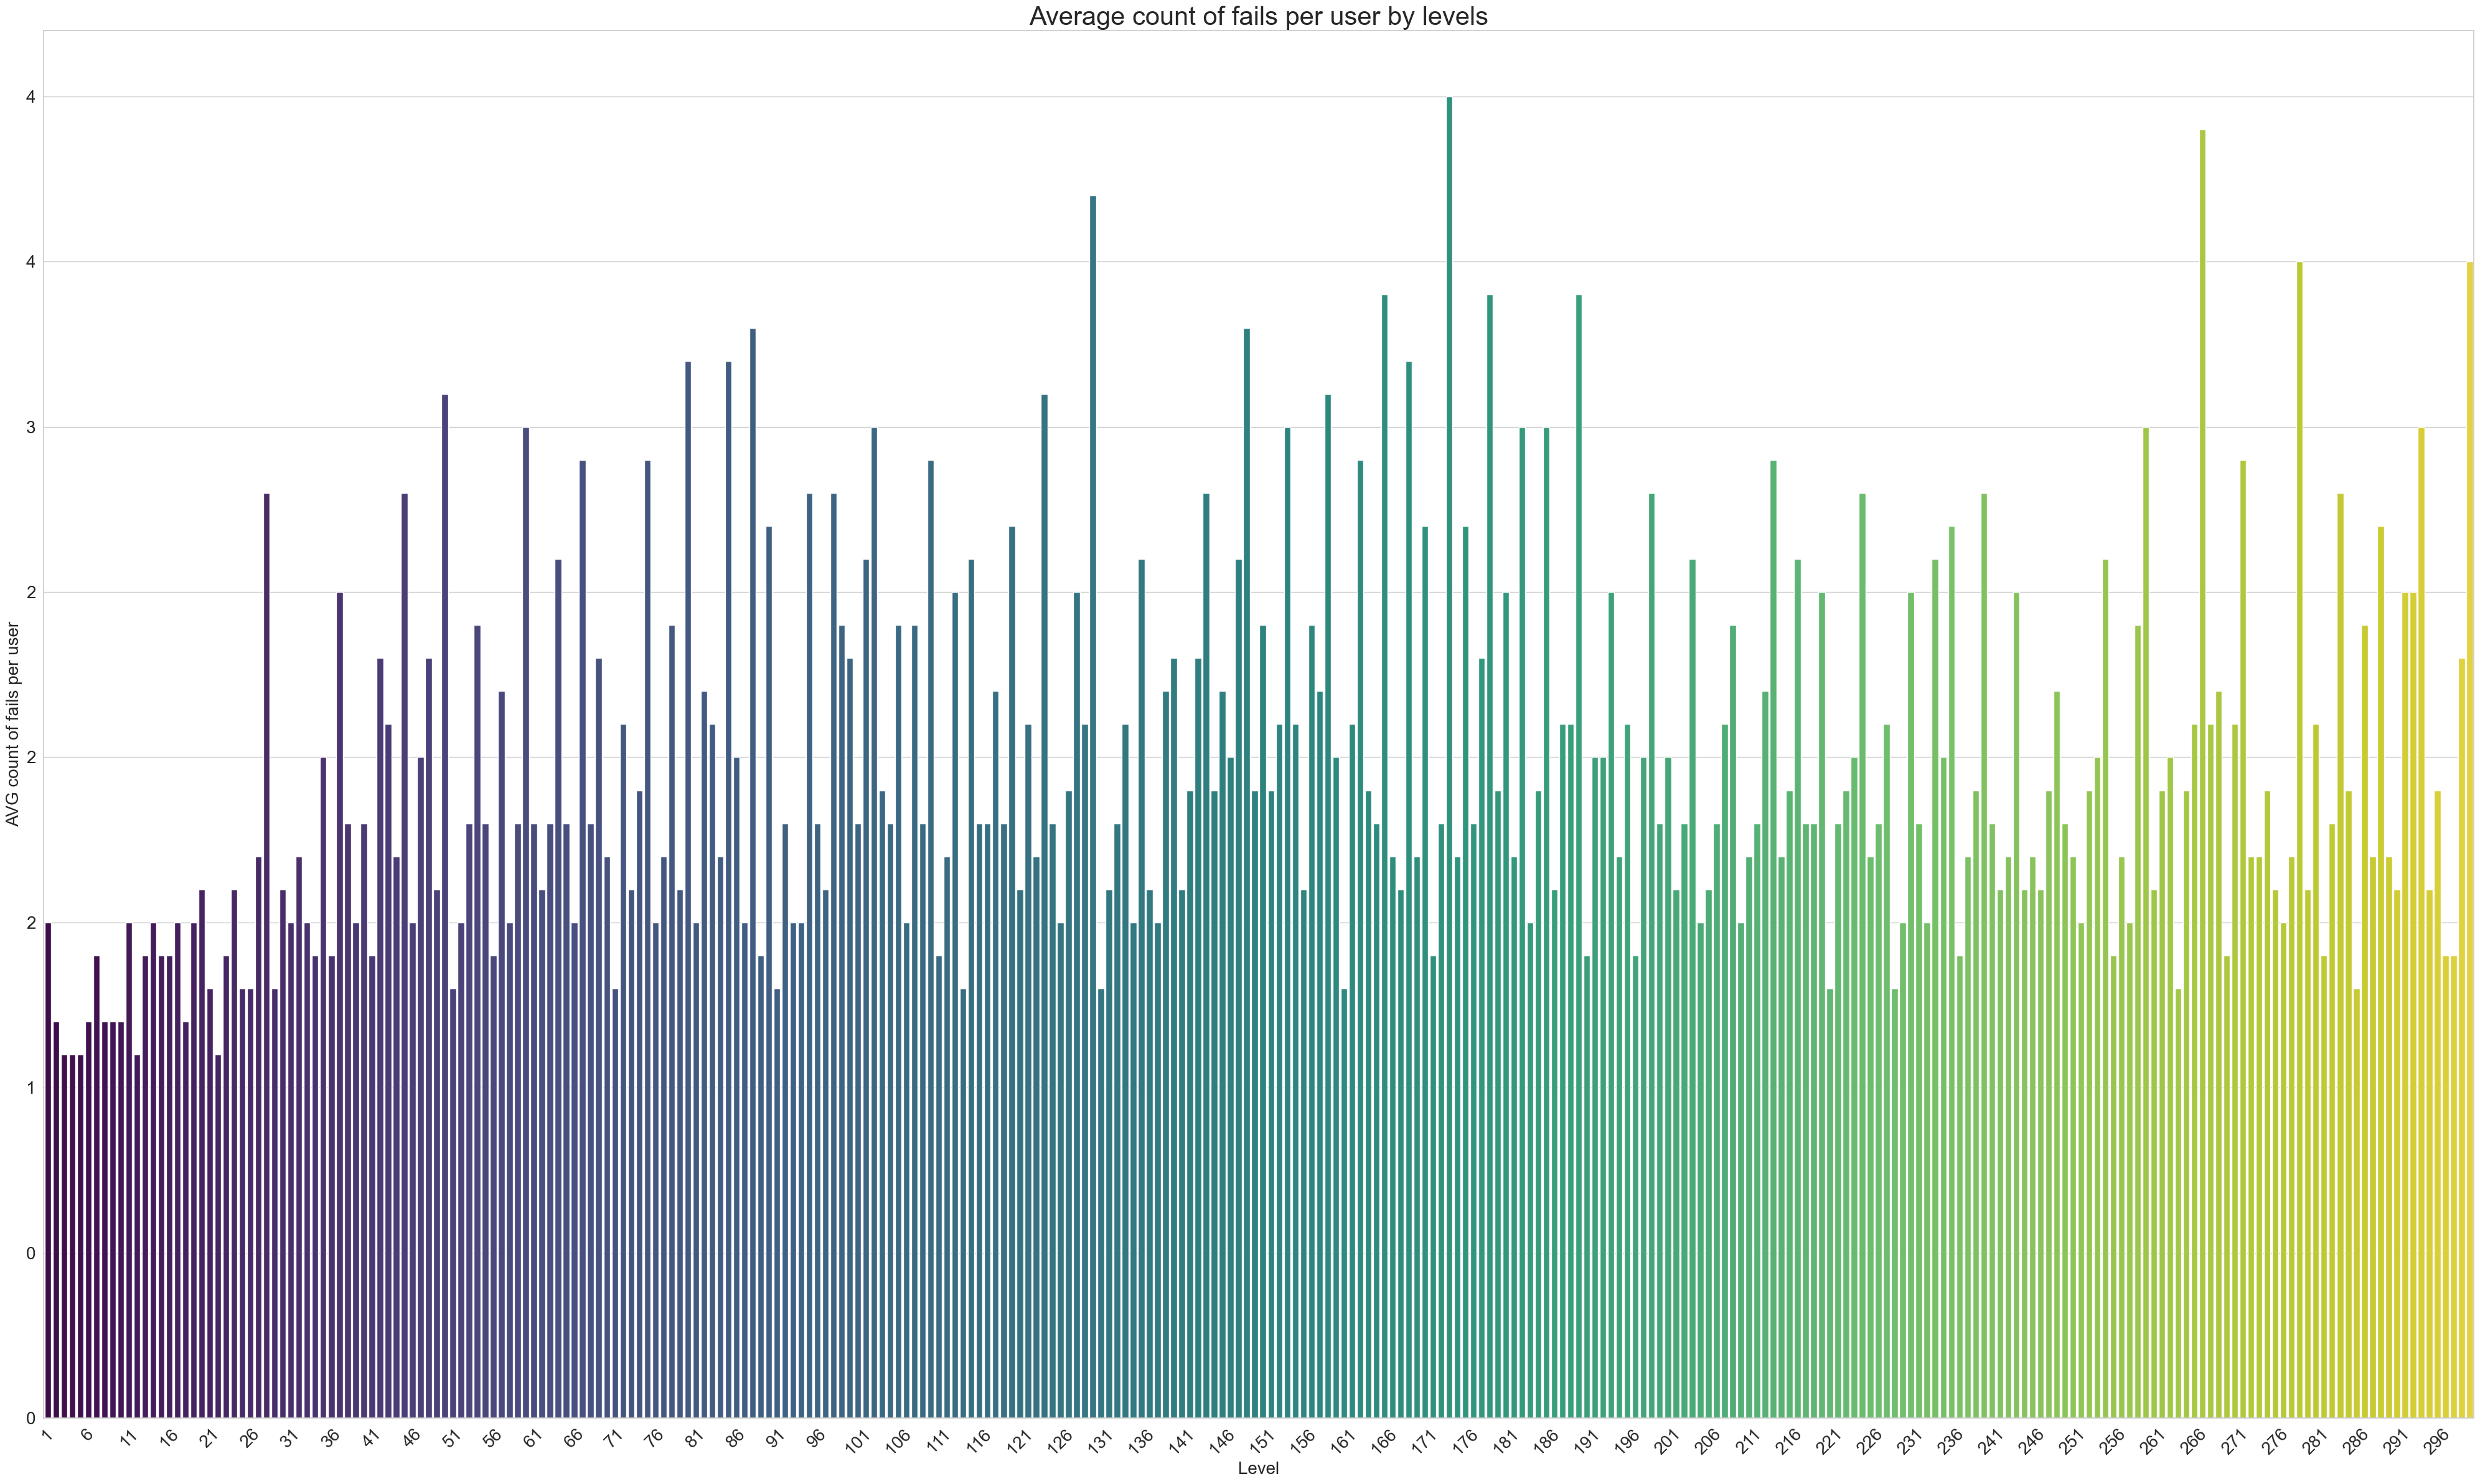

In [23]:
'AVG count of fails per user'

# Building a Chart with the average count of fails per user by levels

# Setting the chart style
sns.set(style="whitegrid")

# Creating a Column Chart Using Seaborn
plt.figure(figsize=(40, 24))
plot = sns.barplot(x='Level', y='AVG count of fails per user', data=funnel_dh, palette='viridis')
plt.xlabel('Level', size=20)
plt.ylabel('AVG count of fails per user', size=20)
plt.title('Average count of fails per user by levels', size=30)

# Setting Y-Axis Percentage Labels
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda value, _: f'{value:.0f}'))
plt.yticks(fontsize=20)

# Display every 10th tick mark on x-axis
plot.set_xticks(range(0, len(funnel_dh['Level']), 5))
plot.set_xticklabels(funnel_dh['Level'][::5], fontsize=20)

plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [27]:
# Sorting data by avg count of fails per user
funnel_dh_sorted_avg_fails = funnel_dh.sort_values(by=['AVG count of fails per user'], ascending = False)
funnel_dh_sorted_avg_fails.set_index('Level', inplace=True)
selected_columns = ['AVG count of fails per user', 'Count of failes','Users failed the level','Total users','Conversion rate difference']
funnel_dh_sorted_avg_fails[selected_columns].head(15)

AVG count of fails per user  Count of failes  Users failed the level  \
Level                                                                         
174                            4.0             1217                     307   
267                            3.9              158                      41   
130                            3.7             3038                     821   
300                            3.5               88                      25   
279                            3.5              105                      30   
179                            3.4              932                     275   
190                            3.4              683                     198   
166                            3.4             1211                     352   
88                             3.3             6756                    2077   
149                            3.3             1717                     520   
80                             3.2             7911                    2465   
85                             3.2             7102                    2213   
169                            3.2             1034                     327   
124                            3.1             2807                     915   
159                            3.1             1345                     428   

       Total users  Conversion rate difference  
Level                                           
174            329                        9.67  
267             46                        4.55  
130            880                       11.82  
300             29                        3.57  
279             35                       -5.41  
179            307                       14.55  
190            223                       10.40  
166            400                        9.89  
88            2257                       13.42  
149            592                        5.71  
80            2690                       11.07  
85            2418                        9.36  
169            373                       10.03  
124           1021                        8.50  
159            476                       10.70

<h1>Computing level difficulty</h1>
    
Basicly, within all games, there is a mix of easier and tougher levels. Luck and individual skill make the number of attempts required to pass a level different from player to player. The assumption is that difficult levels require more attempts on average than easier ones. That is, the harder a level is, the lower the probability to pass that level in a single attempt is.

A simple approach to model this probability is as a Bernoulli process; as a binary outcome (you either win or lose) characterized by a single parameter pwin: the probability of winning the level in a single attempt. This probability can be estimated for each level as: p_win = wins/attempts

So, we already computed the difficulty p_win for each level above, and now let's create visualizization to see the results.

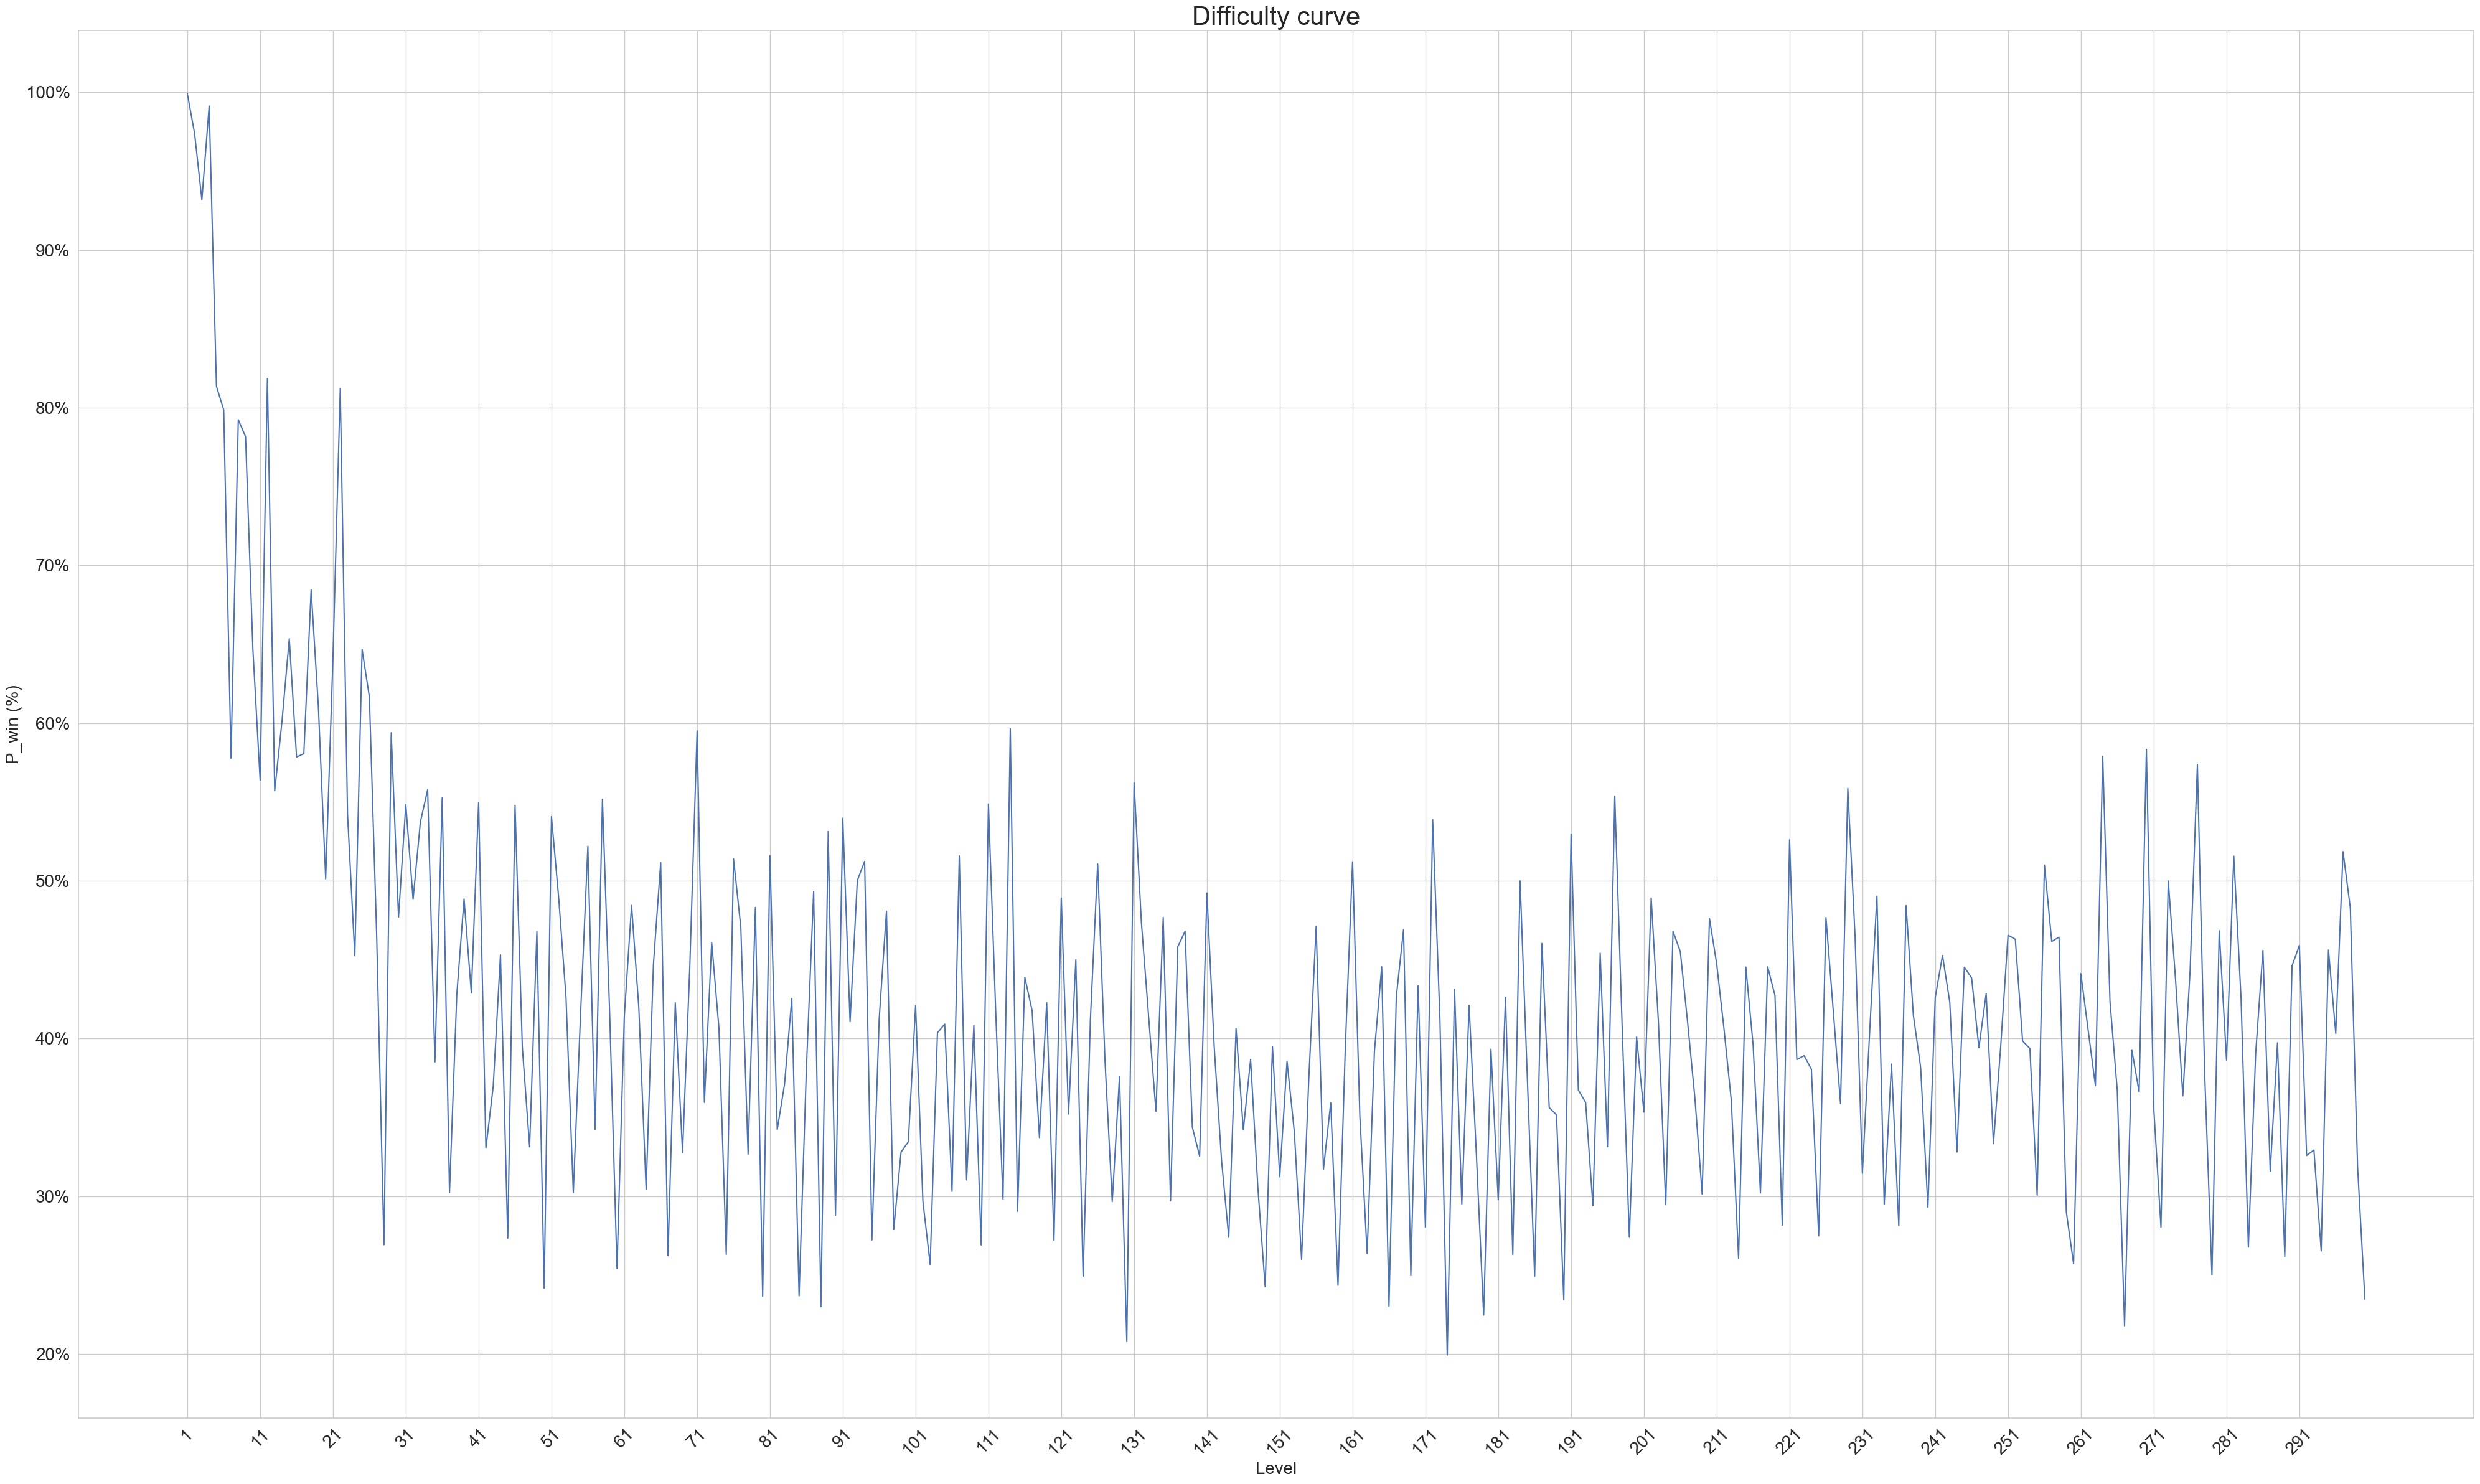

In [62]:
# Creating the linechart with the Difficulty curve

# Creating the chart
plt.figure(figsize=(40, 24))
plt.errorbar(funnel_dh['Level'], funnel_dh['P_win'])

# Setting axis labels and titles
plt.xlabel('Level', size=20)
plt.ylabel('P_win (%)', size=20)
plt.title('Difficulty curve', size=30)

# Setting Y-Axis Percentage Labels
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda value, _: f'{value*100:.0f}%'))
plt.yticks(fontsize=20)

# Setting X-Axis
plt.xticks(funnel_dh['Level'][::10], rotation=45, fontsize=20)

plt.tight_layout()
plt.show()

We now have the difficulty for all the 300 levels. Keep in mind that, as we measure difficulty as the probability to pass a level in a single attempt, a lower value (a smaller probability of winning the level) implies a higher level difficulty. 
And as a result we can see from the chart that the hardest levels are starting from the level 28.

What constitutes a hard level is subjective. However, let's say 30% in our case it's the border, and label levels with pwin < 35% as hard. We can add to the plot horizontal line highlighting the hard levels.

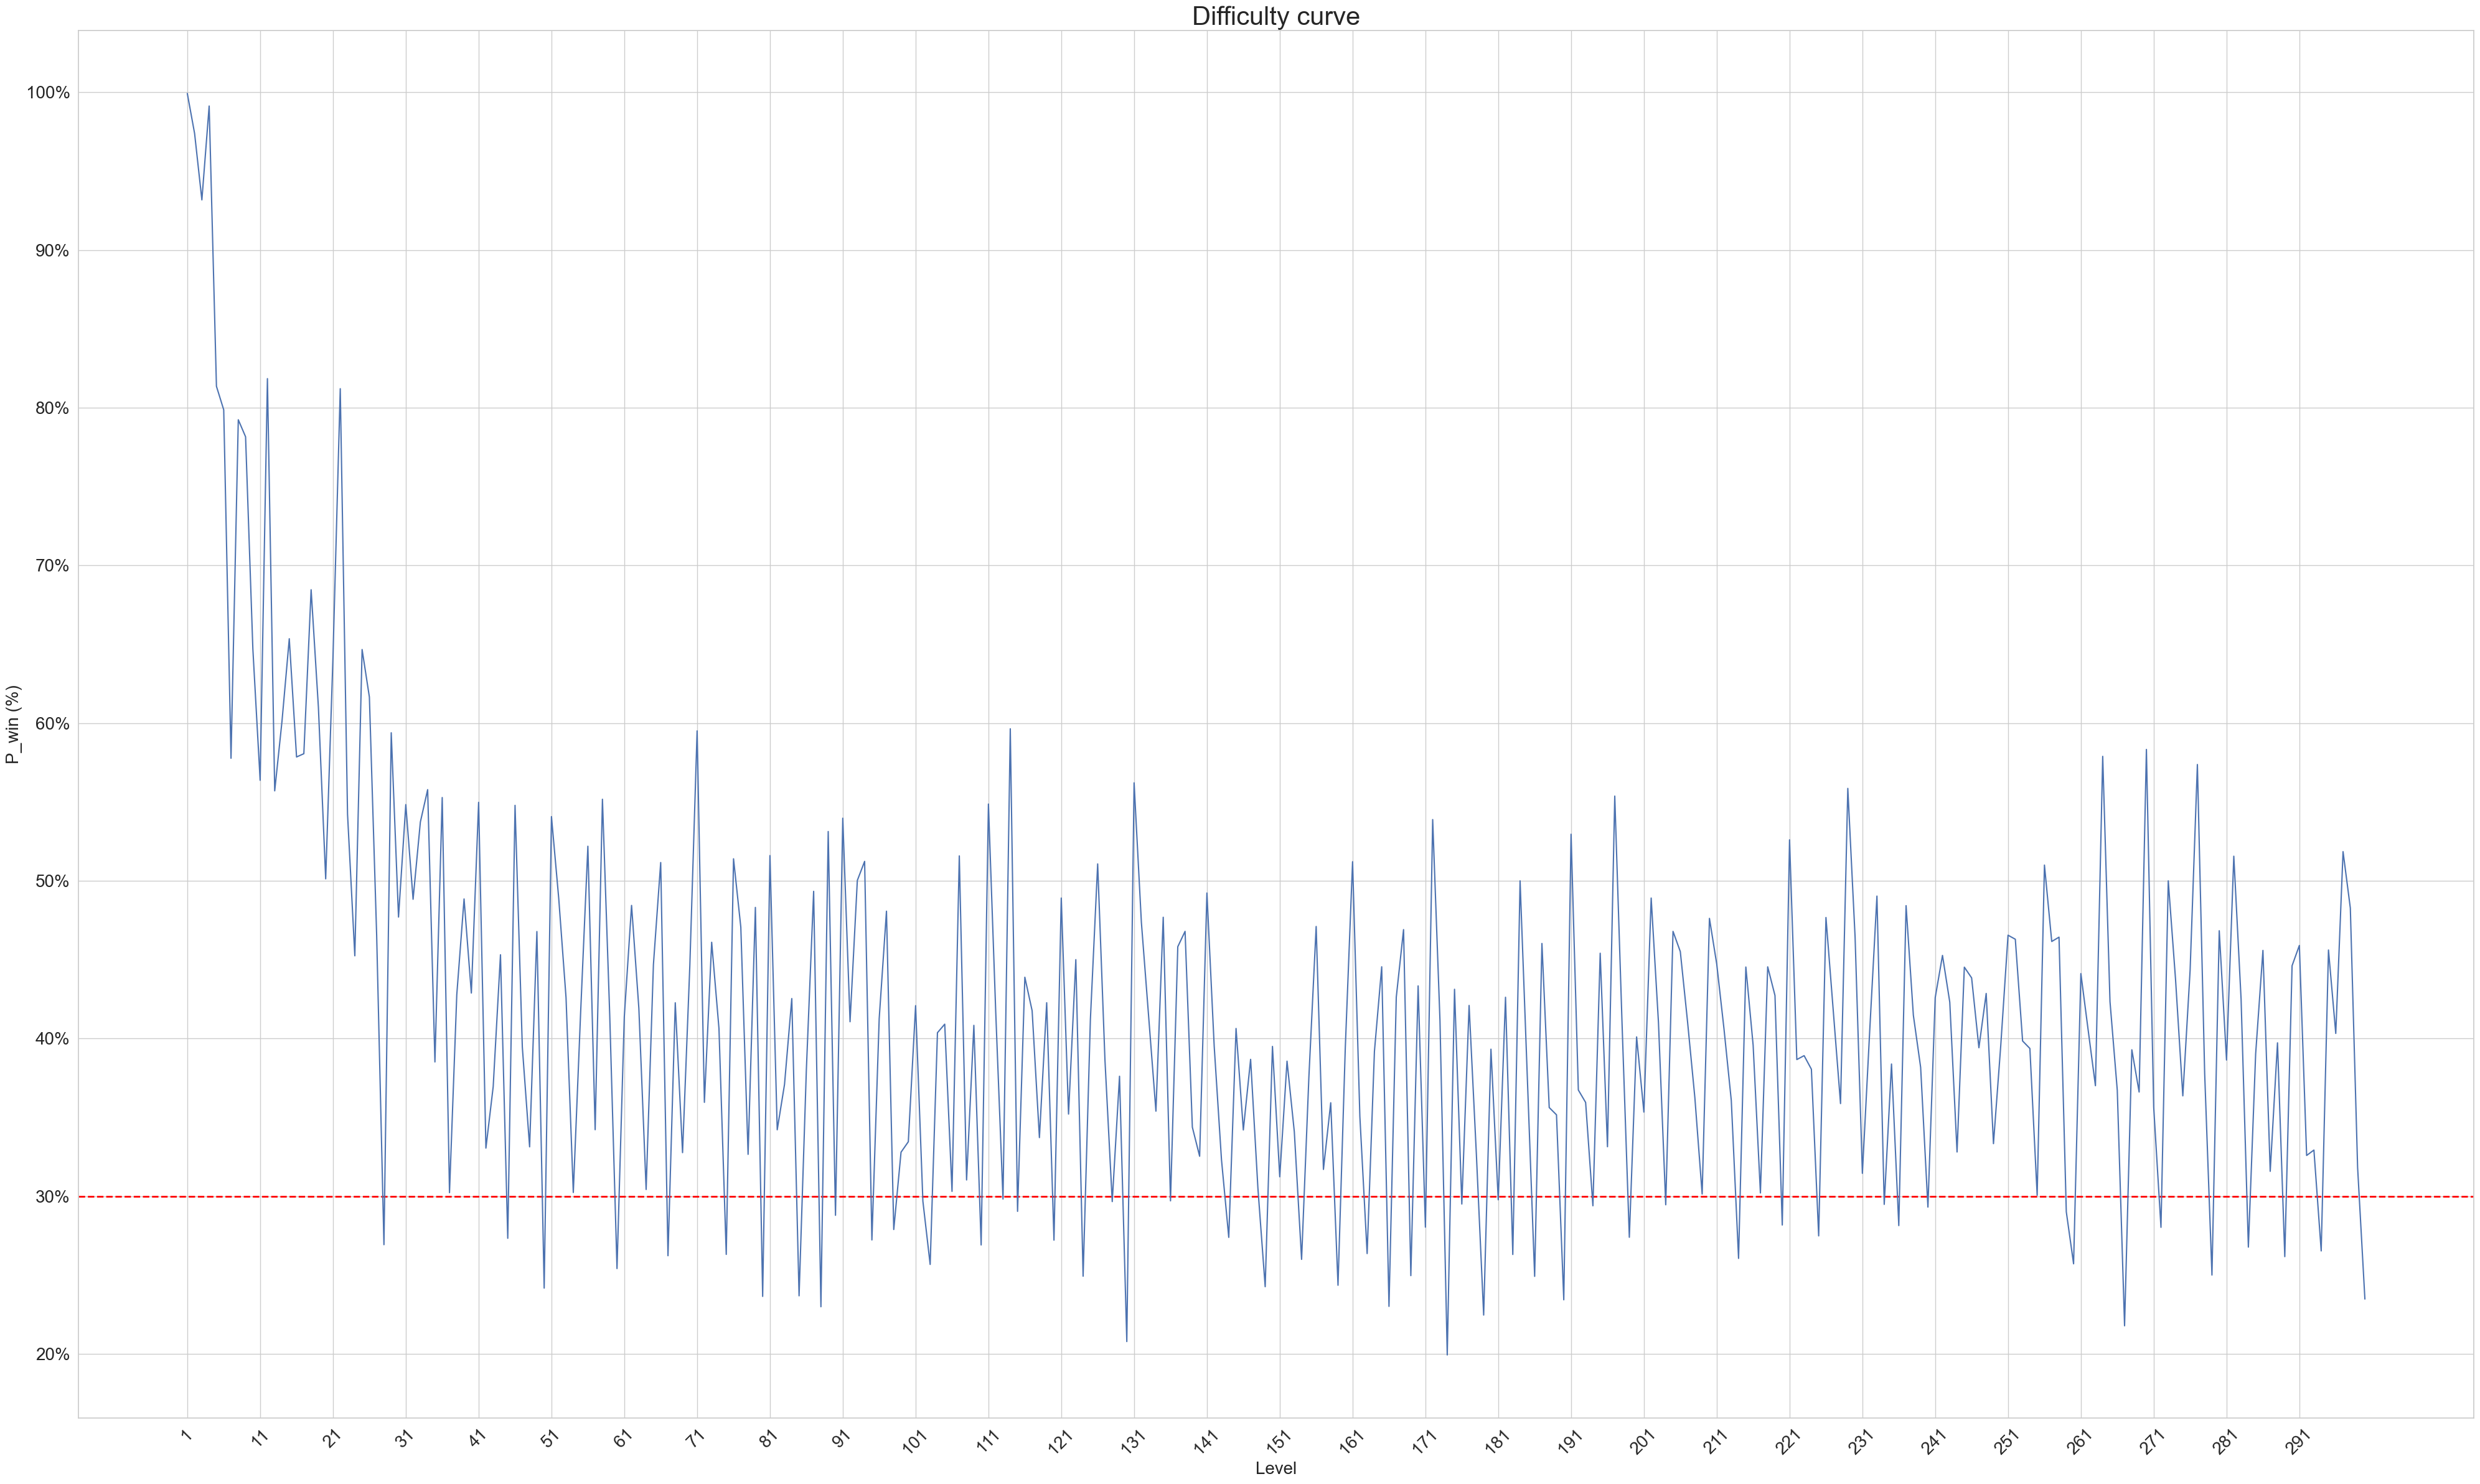

In [66]:
plt.figure(figsize=(40, 24))
plt.errorbar(funnel_dh['Level'], funnel_dh['P_win'])

plt.xlabel('Level', size=20)
plt.ylabel('P_win (%)', size=20)
plt.title('Difficulty curve', size=30)

plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda value, _: f'{value*100:.0f}%'))
plt.yticks(fontsize=20)

# Adding hline at 30%
plt.axhline(y=0.30, color='red', linestyle='--', linewidth=2)

plt.xticks(funnel_dh['Level'][::10], rotation=45, fontsize=20)

plt.tight_layout()
plt.show()

We already calculated above in for function standard error of difficulty, and we can visualise on the chart error bar for each level. Let's do this!

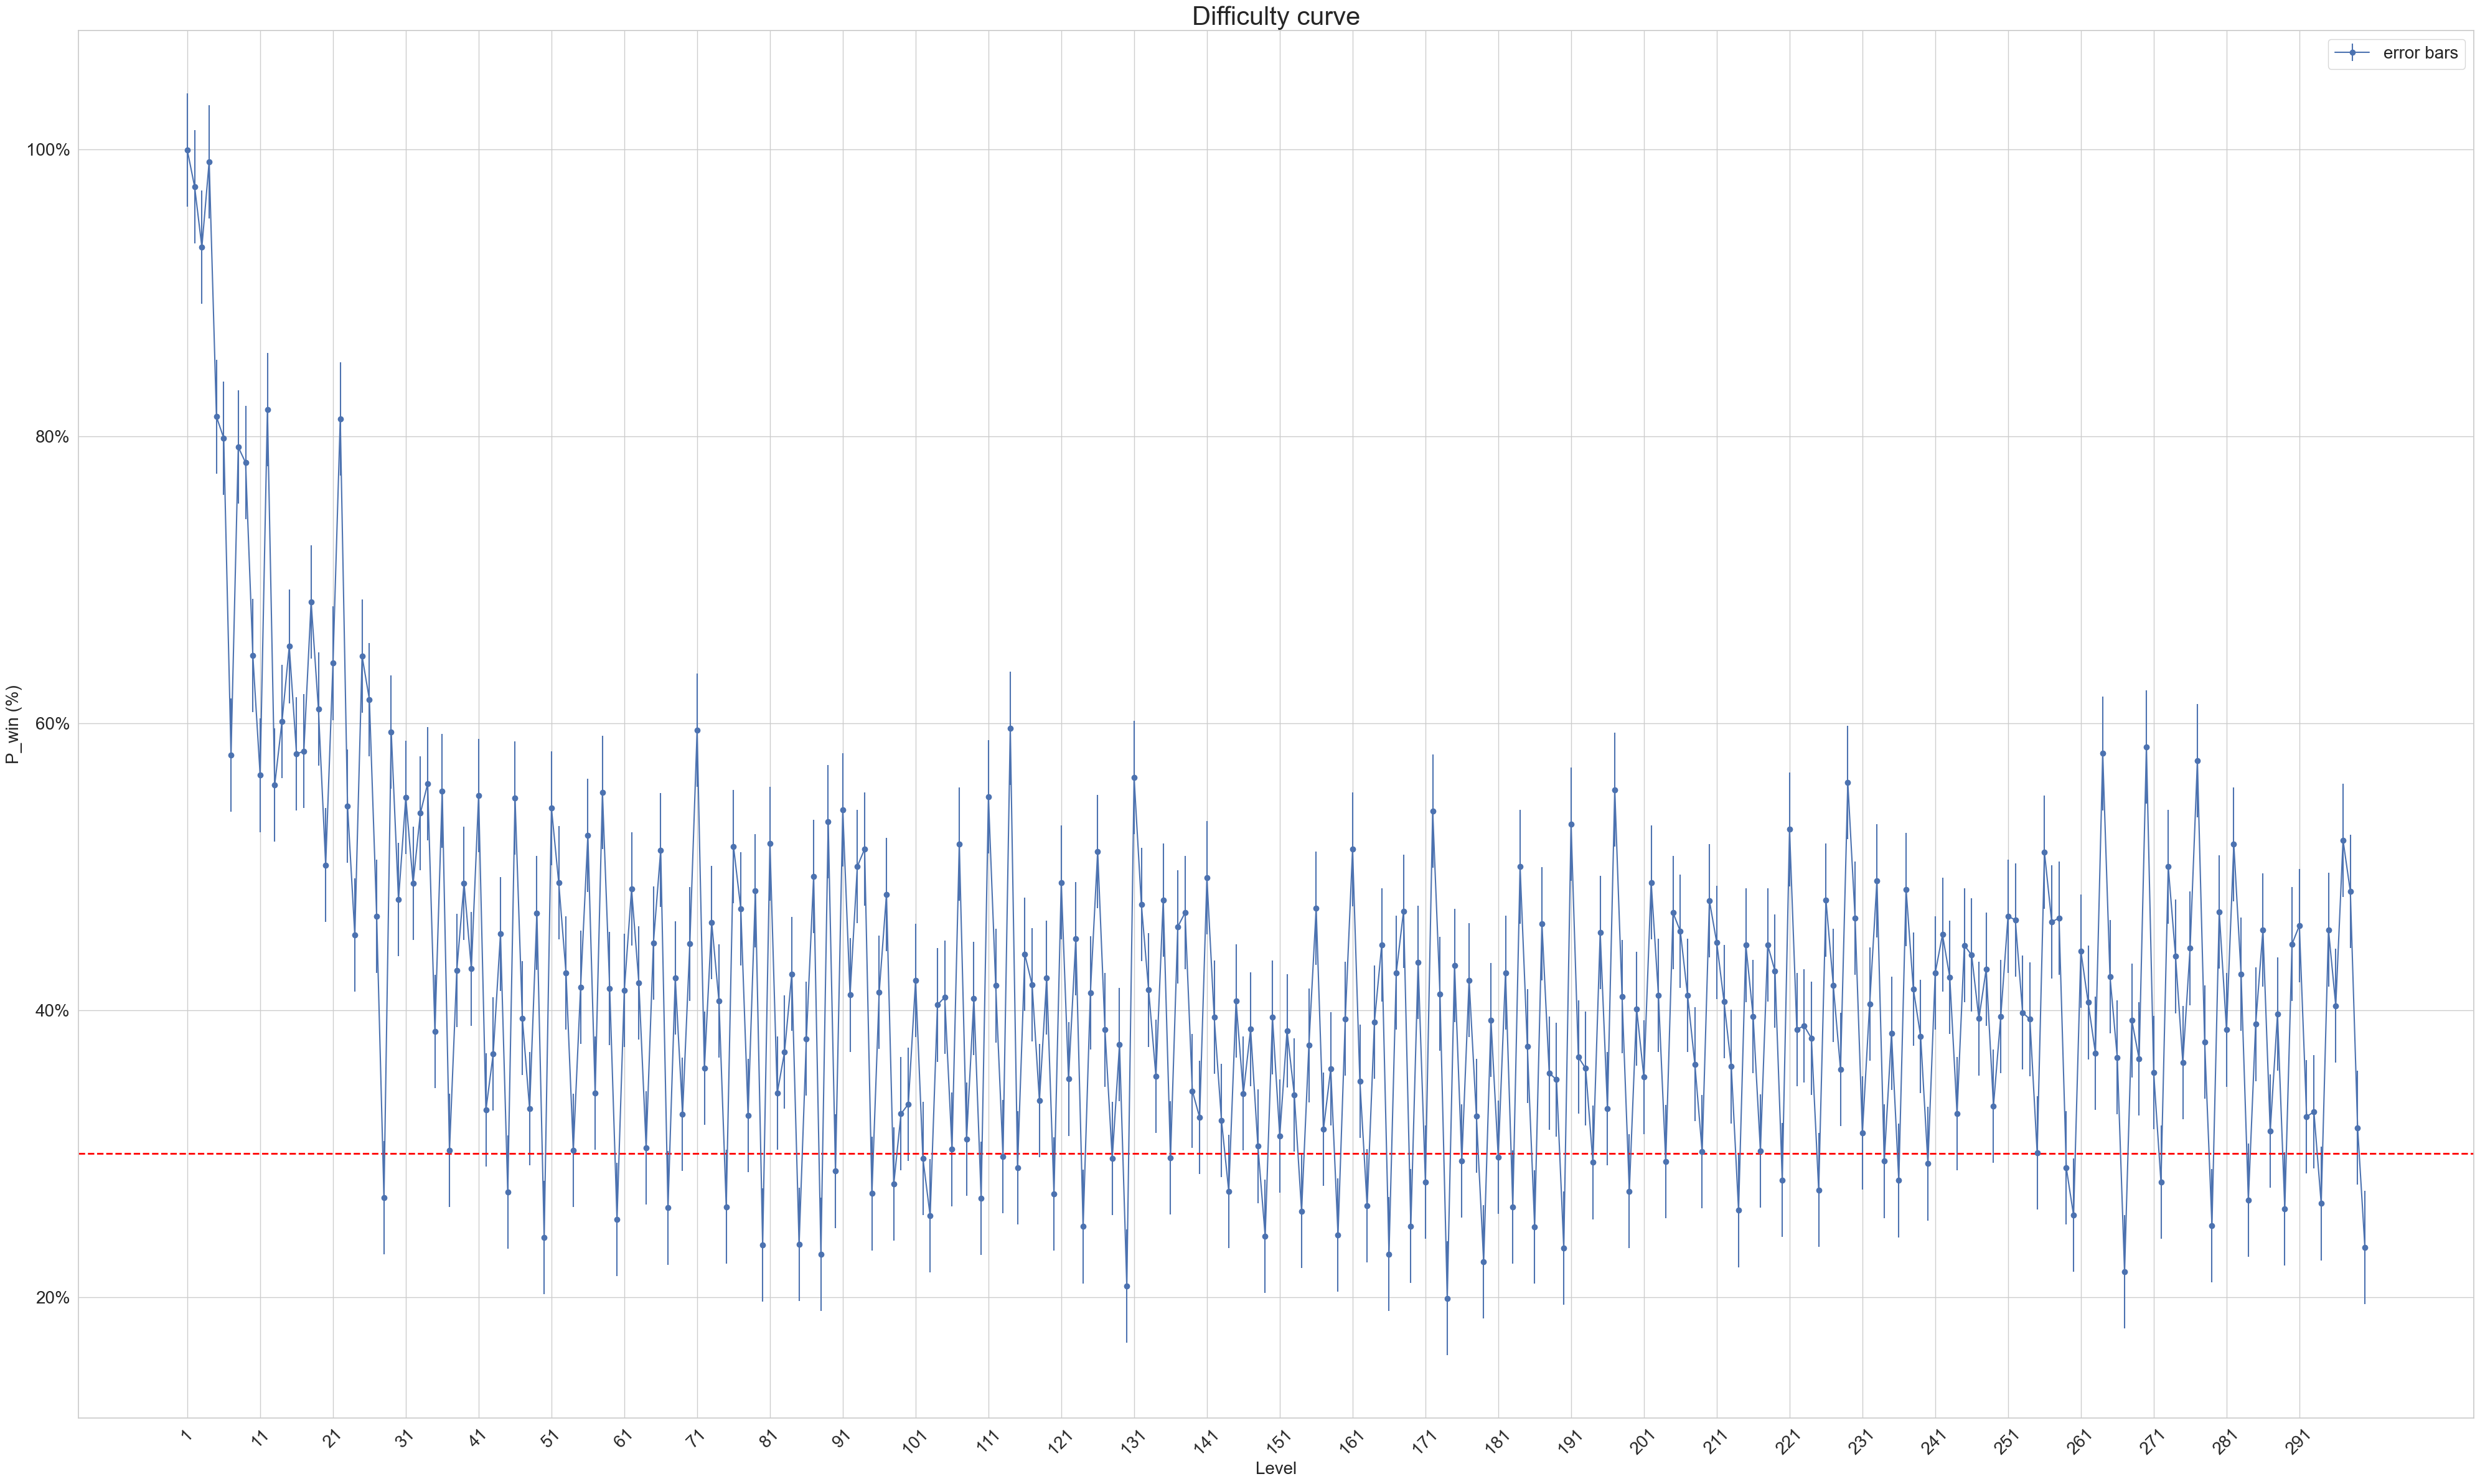

In [67]:
# Adding std_error bars
plt.figure(figsize=(40, 24))
plt.errorbar(funnel_dh['Level'], funnel_dh['P_win'], yerr=std_error, fmt='-o', label='error bars')

plt.xlabel('Level', size=20)
plt.ylabel('P_win (%)', size=20)
plt.title('Difficulty curve', size=30)

plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda value, _: f'{value*100:.0f}%'))
plt.yticks(fontsize=20)

plt.axhline(y=0.30, color='red', linestyle='--', linewidth=2)

plt.xticks(funnel_dh['Level'][::10], rotation=45, fontsize=20)

plt.legend(fontsize=20)

plt.tight_layout()
plt.show()

<h1>Correlation</h1>

Let's check if there is a correlation between the number of failed attempts to complete a level and the percentage drop in conversion.

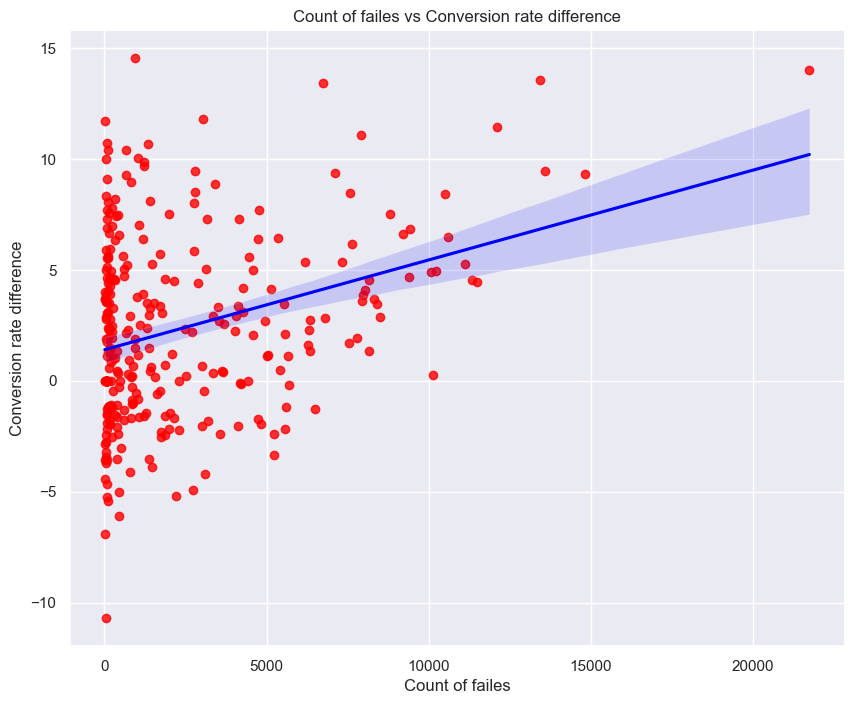

In [25]:
# Looking at correlation
sns.set_theme(style = 'darkgrid')

plt.figure(figsize=(10, 8))
sns.regplot(x = 'Count of failes', y = 'Conversion rate difference', data=funnel_dh, scatter_kws = {'color': 'red'},line_kws = {'color': 'blue'}).set_title('Count of failes vs Conversion rate difference')

plt.show()

From this graph we can determine that there is no segnificant relationship between the difference in conversion and the number of attempts to pass the level.

<h1>Summary</h1>

- The Conversion Rate Funnel appears healthy, with a gradual and smooth decline in the overall conversion rate. Nevertheless, the team should focus on levels with the most significant drops in conversion and explore potential areas for improvement.

- The Sequential Conversion Rate chart also presents a positive outlook, with minimum and maximum indicators evenly distributed across levels, and no extreme values in the dataset.

- However, there are some extremely high numbers in the count of fails for certain levels. The design team should investigate whether these numbers correlate with the developed difficulty curve of the levels. Further analysis of these levels is necessary to understand the reasons behind this behavior. Despite the high count of fails, examining the correlation between the count of fails and the conversion rate difference reveals no significant relationship. This implies that the total count of fails does not significantly impact the drop in conversion rate. One specific recommendation is to investigate Level 28, which exhibits an extremely high number of fails and a substantial drop in conversion rate.